<a href="https://www.kaggle.com/code/lccburk/feature-engineering-and-random-forest-prediction?scriptVersionId=145049630" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Feature Engineering and Random Forest Prediction to Detect Sleep States
In this notebook I... 
- Use the Polars library to load and transform the CMI dataset and incorporate features inspired by the work done in my [Sleep Data Exploration](https://www.kaggle.com/code/lccburk/sleep-data-exploration) notebook. 
- Import and implement the [Event Detection AP](https://www.kaggle.com/code/metric/event-detection-ap/notebook) score function to validate results prior to submission.
- Define helper functions to create training sets and formatted submissions based on classifier results.
- Train a Random Forest classifier (as well as gradient boost classifier) and use the above work to validate and create a submission.

Please feel free to use any and all code below in your own work. This is my first ever Kaggle competition so feedback is welcomed, and if you do use my code I would really appreciate being credited so that people can see my work and profile. Thanks!

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import polars as pl
import datetime 
from tqdm import tqdm

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from metric import score # Import event detection ap score function

# These are variables to be used by the score function
column_names = {
    'series_id_column_name': 'series_id',
    'time_column_name': 'step',
    'event_column_name': 'event',
    'score_column_name': 'score',
}

tolerances = {
    'onset': [12, 36, 60, 90, 120, 150, 180, 240, 300, 360], 
    'wakeup': [12, 36, 60, 90, 120, 150, 180, 240, 300, 360]
}

## Importing data

In [ ]:
# Importing data 

# Column transformations

dt_transforms = [
    pl.col('timestamp').str.to_datetime(), 
    (pl.col('timestamp').str.to_datetime().dt.year()-2000).cast(pl.UInt8).alias('year'), 
    pl.col('timestamp').str.to_datetime().dt.month().cast(pl.UInt8).alias('month'),
    pl.col('timestamp').str.to_datetime().dt.day().cast(pl.UInt8).alias('day'), 
    pl.col('timestamp').str.to_datetime().dt.hour().cast(pl.UInt8).alias('hour')
]

data_transforms = [
    pl.col('anglez').cast(pl.Int16), # Casting anglez to 16 bit integer
    (pl.col('enmo')*1000).cast(pl.UInt16), # Convert enmo to 16 bit uint
]

train_series = pl.scan_parquet('/kaggle/input/child-mind-institute-detect-sleep-states/train_series.parquet').with_columns(
    dt_transforms + data_transforms
    )

train_events = pl.read_csv('/kaggle/input/child-mind-institute-detect-sleep-states/train_events.csv').with_columns(
    dt_transforms
    ).drop_nulls()

test_series = pl.scan_parquet('/kaggle/input/child-mind-institute-detect-sleep-states/test_series.parquet').with_columns(
    dt_transforms + data_transforms
    )

# Removing null events and nights with mismatched counts from series_events
mismatches = train_events.drop_nulls().group_by(['series_id', 'night']).agg([
    ((pl.col('event') == 'onset').sum() == (pl.col('event') == 'wakeup').sum()).alias('balanced')
    ]).sort(by=['series_id', 'night']).filter(~pl.col('balanced'))

for mm in mismatches.to_numpy(): 
    train_events = train_events.filter(~((pl.col('series_id') == mm[0]) & (pl.col('night') == mm[1])))


# Getting series ids as a list for convenience
series_ids = train_events['series_id'].unique(maintain_order=True).to_list()

# Updating train_series to only keep these series ids
train_series = train_series.filter(pl.col('series_id').is_in(series_ids))

## Feature Engineering

The features in this model will consist of
- The current`hour`.
- Rolling aggregates (mean and max) of `anglez` and `enmo` over a variety of window sizes, from 5 minutes to 8 hours. 
- Rolling aggregates (mean and max) of `anglez` and `enmo` [**total variation**](https://en.wikipedia.org/wiki/Total_variation) (or *first variation*, i.e. 1v) over a variety of window sizes, from 5 minutes to 8 hours.

#### Motivation for using total variation 

The motivation for using rolling total variation as a feature comes from the observation that during sleeping periods `anglez` resembles a pure [jump process](https://en.wikipedia.org/wiki/Jump_process), while during wakeful periods it resembles a [diffusion process](https://en.wikipedia.org/wiki/Diffusion_process), as shown in the following data sample:

<img src="https://media.licdn.com/dms/image/D5612AQHondzoUGc1tA/article-inline_image-shrink_1000_1488/0/1695767830342?e=1701907200&v=beta&t=3Zf5RuZpGNGHUyAl7g-B7J9ftZaQrGPze4l1XegKkpU" width="800" />

(See my [Sleep Data Exploration](https://www.kaggle.com/code/lccburk/sleep-data-exploration) notebook for data visualization functions.)

Importantly, jump and diffusion processes can be distinguished by what is known as their total variation - essentially, the sum total of the absolute differences between the points. For diffusion processes, which jiggle around constantly, the total variation is infinite, while for jump processes, which only change by finite amounts a countable number of times, the total variation is finite.

<img src="https://media.licdn.com/dms/image/D5612AQGNsJtKsGREyQ/article-inline_image-shrink_1500_2232/0/1696293678614?e=1701907200&v=beta&t=iTZutqlUHm7pvv-d1pKAHoAYO5Va9Z_1Tjjee3B4dgg" width="650" />

For non-continuous, evenly sampled functions such as our time series, the total variation of a function $f(t)$ on an interval $[a,b]$ can be defined simply as

$$V_a^b(f) := \sum_{j=0}^{n-1} |f(t_{j+1}) - f(t_j)|$$

where $t_0=a$, $t_n=b$, and $\forall j: t_{j+1}-t_j = \frac{a-b}{n}$. This can be calculated efficiently using Polars' built in `.diff()` and `.abs()` functions. 

These features will give the classification model information which characterizes the stochastic behavior of the variable in the recent past, which can be much more useful for classifying sleep state than the variable value itself.
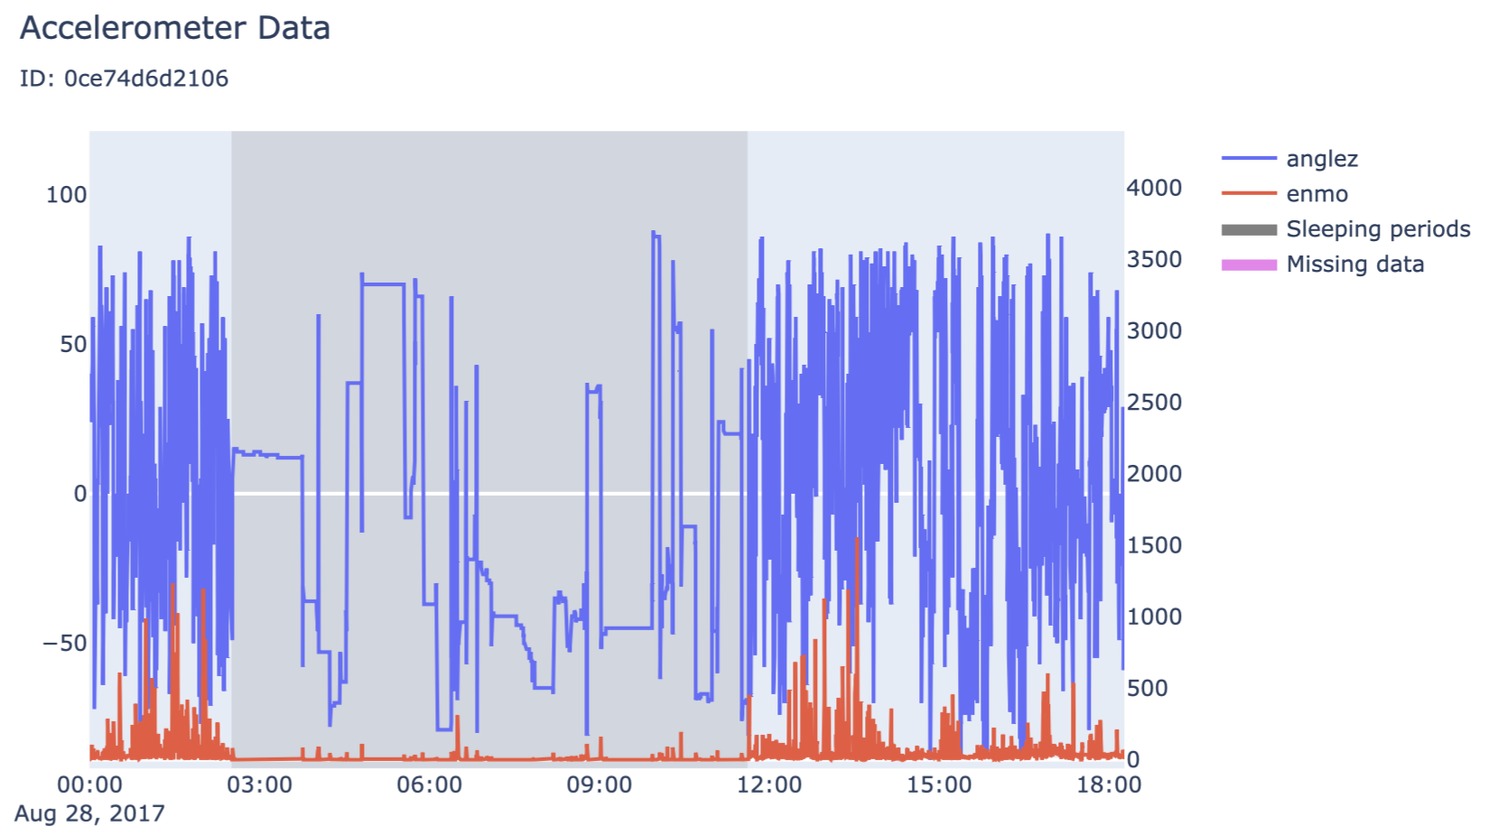
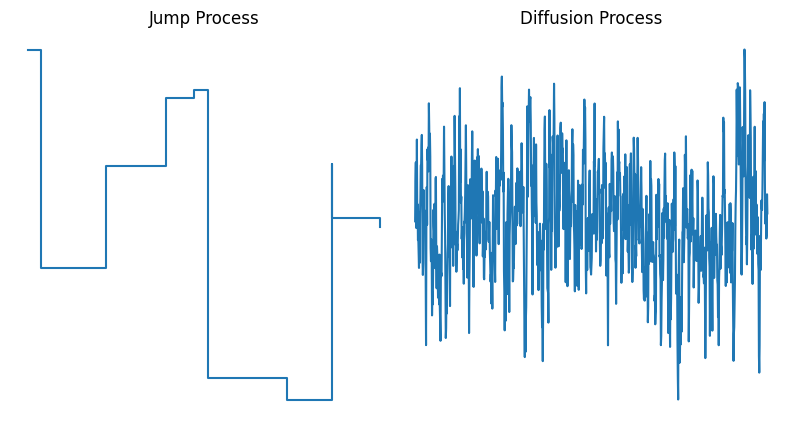

In [ ]:
features, feature_cols = [pl.col('hour')], ['hour']

for mins in [5, 30, 60*2, 60*8] :
    features += [
        pl.col('enmo').rolling_mean(12 * mins, center=True, min_periods=1).abs().cast(pl.UInt16).alias(f'enmo_{mins}m_mean'),
        pl.col('enmo').rolling_max(12 * mins, center=True, min_periods=1).abs().cast(pl.UInt16).alias(f'enmo_{mins}m_max')
    ]

    feature_cols += [ 
        f'enmo_{mins}m_mean', f'enmo_{mins}m_max'
    ]

    # Getting first variations
    for var in ['enmo', 'anglez'] :
        features += [
            (pl.col(var).diff().abs().rolling_mean(12 * mins, center=True, min_periods=1)*10).abs().cast(pl.UInt32).alias(f'{var}_1v_{mins}m_mean'),
            (pl.col(var).diff().abs().rolling_max(12 * mins, center=True, min_periods=1)*10).abs().cast(pl.UInt32).alias(f'{var}_1v_{mins}m_max')
        ]

        feature_cols += [ 
            f'{var}_1v_{mins}m_mean', f'{var}_1v_{mins}m_max'
        ]

id_cols = ['series_id', 'step', 'timestamp']

train_series = train_series.with_columns(
    features
).select(id_cols + feature_cols)

test_series = test_series.with_columns(
    features
).select(id_cols + feature_cols)

In [ ]:
def make_train_dataset(train_data, train_events, drop_nulls=False) :
    
    series_ids = train_data['series_id'].unique(maintain_order=True).to_list()
    X, y = pl.DataFrame(), pl.DataFrame()
    for idx in tqdm(series_ids) : 
        
        # Normalizing sample features
        sample = train_data.filter(pl.col('series_id')==idx).with_columns(
            [(pl.col(col) / pl.col(col).std()).cast(pl.Float32) for col in feature_cols if col != 'hour']
        )
        
        events = train_events.filter(pl.col('series_id')==idx)
        
        if drop_nulls : 
            # Removing datapoints on dates where no data was recorded
            sample = sample.filter(
                pl.col('timestamp').dt.date().is_in(events['timestamp'].dt.date())
            )
        
        X = X.vstack(sample[id_cols + feature_cols])

        onsets = events.filter((pl.col('event') == 'onset') & (pl.col('step') != None))['step'].to_list()
        wakeups = events.filter((pl.col('event') == 'wakeup') & (pl.col('step') != None))['step'].to_list()

        # NOTE: This will break if there are event series without any recorded onsets or wakeups
        y = y.vstack(sample.with_columns(
            sum([(onset <= pl.col('step')) & (pl.col('step') <= wakeup) for onset, wakeup in zip(onsets, wakeups)]).cast(pl.Boolean).alias('asleep')
            ).select('asleep')
            )
    
    y = y.to_numpy().ravel()
    
    return X, y

In [ ]:
def get_events(series, classifier) :
    '''
    Takes a time series and a classifier and returns a formatted submission dataframe.
    '''
    
    series_ids = series['series_id'].unique(maintain_order=True).to_list()
    events = pl.DataFrame(schema={'series_id':str, 'step':int, 'event':str, 'score':float})

    for idx in tqdm(series_ids) : 

        # Collecting sample and normalizing features
        scale_cols = [col for col in feature_cols if (col != 'hour') & (series[col].std() !=0)]
        X = series.filter(pl.col('series_id') == idx).select(id_cols + feature_cols).with_columns(
            [(pl.col(col) / series[col].std()).cast(pl.Float32) for col in scale_cols]
        )

        # Applying classifier to get predictions and scores
        preds, probs = classifier.predict(X[feature_cols]), classifier.predict_proba(X[feature_cols])[:, 1]

        #NOTE: Considered using rolling max to get sleep periods excluding <30 min interruptions, but ended up decreasing performance
        X = X.with_columns(
            pl.lit(preds).cast(pl.Int8).alias('prediction'), 
            pl.lit(probs).alias('probability')
                        )
        
        # Getting predicted onset and wakeup time steps
        pred_onsets = X.filter(X['prediction'].diff() > 0)['step'].to_list()
        pred_wakeups = X.filter(X['prediction'].diff() < 0)['step'].to_list()
        
        if len(pred_onsets) > 0 : 
            
            # Ensuring all predicted sleep periods begin and end
            if min(pred_wakeups) < min(pred_onsets) : 
                pred_wakeups = pred_wakeups[1:]

            if max(pred_onsets) > max(pred_wakeups) :
                pred_onsets = pred_onsets[:-1]

            # Keeping sleep periods longer than 30 minutes
            sleep_periods = [(onset, wakeup) for onset, wakeup in zip(pred_onsets, pred_wakeups) if wakeup - onset >= 12 * 30]

            for onset, wakeup in sleep_periods :
                # Scoring using mean probability over period
                score = X.filter((pl.col('step') >= onset) & (pl.col('step') <= wakeup))['probability'].mean()

                # Adding sleep event to dataframe
                events = events.vstack(pl.DataFrame().with_columns(
                    pl.Series([idx, idx]).alias('series_id'), 
                    pl.Series([onset, wakeup]).alias('step'),
                    pl.Series(['onset', 'wakeup']).alias('event'),
                    pl.Series([score, score]).alias('score')
                ))

    # Adding row id column
    events = events.to_pandas().reset_index().rename(columns={'index':'row_id'})

    return events

## Training Models

In [ ]:
'''
from sklearn.model_selection import train_test_split

train_ids, val_ids = train_test_split(series_ids, train_size=0.7, random_state=42)

# We will collect datapoints at 10 minute intervals for training for validating
train_data = train_series.filter(pl.col('series_id').is_in(train_ids)).take_every(12 * 10).collect()

val_data = train_series.filter(pl.col('series_id').is_in(val_ids)).collect()
val_solution = train_events.filter(pl.col('series_id').is_in(val_ids)).select(['series_id', 'event', 'step']).to_pandas()
'''
# Collecting datapoints at every 5 minutes
train_data = train_series.filter(pl.col('series_id').is_in(series_ids)).take_every(12 * 5).collect()


In [ ]:
# Creating train dataset
X_train, y_train = make_train_dataset(train_data, train_events)

### Training and validating random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(random_state=42)

# Training classifier
rf_classifier = RandomForestClassifier(n_estimators=500,
                                    min_samples_leaf=50,
                                    random_state=42,
                                    n_jobs=-1)

rf_classifier.fit(X_train[feature_cols], y_train)

In [ ]:
# Plotting feature importances
px.bar(x=feature_cols, 
       y=rf_classifier.feature_importances_,
       title='Random forest feature importances'
      )

In [ ]:
# Checking performance on validation set
#rf_submission = get_events(val_data, rf_classifier)

#print(f"Random forest score: {score(val_solution, rf_submission, tolerances, **column_names)}")

In [ ]:
# Saving classifier 
import pickle
with open('rf_classifier_5m_8h.pkl', 'wb') as f:
    pickle.dump(rf_classifier, f)

#with open('rf_classifier.pkl', 'rb') as f:
#    rf_classifier = pickle.load(f)

### Training and validating gradient boost

In [ ]:
'''# With SKL
from sklearn.ensemble import GradientBoostingClassifier

gb_classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.05, max_depth=10, random_state=42)
gb_classifier.fit(X_train[feature_cols], y_train)'''

In [ ]:
'''# Plotting feature importances
px.bar(x=feature_cols, 
       y=gb_classifier.feature_importances_,
       title='Gradient boosting feature importances'
      )'''

In [ ]:
'''
# Checking performance on validation set
gb_submission = get_events(val_data, gb_classifier)

print(f"Gradient boosting score: {score(val_solution, gb_submission, tolerances, **column_names)}")
'''

## Applying to test data

In [ ]:
# Recovering memory
del train_data 

In [ ]:
# Getting event predictions for test set and saving submission
submission = get_events(test_series.collect(), rf_classifier)
submission.to_csv('submission.csv', index=False)